In [2]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from orgo import Computer
import os
from dotenv import load_dotenv

load_dotenv()


True

In [18]:
from typing_extensions import TypedDict

from typing import Annotated, Optional
import operator

class EventDetails(TypedDict):
    title: str
    date: str
    time: str
    duration: str
    participants: Optional[Annotated[list[str], operator.add]]
    location: Optional[str]
    description: Optional[str]

class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], add_messages]

eventDetails = EventDetails()


In [40]:
@tool
def update_local_event(details: EventDetails):
    """Stores the details of the event for event creation later
    Args:
        details of type EventDetails, which is a TypedDict containing the follow key and values:
        class EventDetails(TypedDict):
            title: str
            date: str
            time: str
            duration: str
            participants: Optional[Annotated[list[str], operator.add]]
            location: Optional[str]
            description: Optional[str]

    
    """
    global eventDetails
    eventDetails = details
    return f"eventDetails has been updated successfully, The current content is:\n {eventDetails} "


@tool
def create_event(details: EventDetails) -> str:
    """
    Call this function to create an event on Google Calendar once
    sufficient information is inside `details`.
    """
    comp = Computer()
    comp.start()

    try:
        # 2.1 Open Google Calendar
        comp.prompt("If needed, open a browser and go to https://calendar.google.com")

        # 2.2 Click the 'Create' (new event) button
        comp.prompt("Click the 'Create' button to start a new event")

        # 2.3 Fill in the core fields
        comp.prompt(f"Set the event title to: {details['title']}")
        comp.prompt(f"Set the event date to: {details['date']}")
        comp.prompt(f"Set the event start time to: {details['time']}")
        comp.prompt(f"Set the event duration to: {details['duration']}")

        # 2.4 Optional attendees
        if participants := details.get("participants"):
            comp.prompt(f"Add guests: {', '.join(participants)}")

        # 2.5 Optional location
        if location := details.get("location"):
            comp.prompt(f"Set location to: {location}")

        # 2.6 Optional description/notes
        if description := details.get("description"):
            comp.prompt(f"Set description to: {description}")

        # 2.7 Save it
        comp.prompt("Click 'Save' to finalize the event")

    except Exception as e:
        comp.stop()
        return f"Error occurred while creating event: {e}"

    comp.stop()
    return "Event created on Google Calendar"

tools = [create_event, update_local_event]

model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [43]:
def agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are an intelligent calendar assistant. Your job is to gather all necessary details to schedule an event, then call the provided @tool create_event(state: EventState) function to place it on Google Calendar.

    1. Required fields: title, date, time, duration.
    2. Optional fields: participants (guests), location, description.
                                  
                                  

    Whenever you receive a user message:
    - Merge any new facts into your internal EventState.
    - If any required field is still missing, ask exactly one follow-up question to obtain it, e.g. “What time is the event?” or “How long will it last?”
    - If all required fields are present but optional fields remain, ask one question at a time for any optional detail the user hasn't yet provided (they may reply “none” to skip).
    - Do not ask about fields the user has already given.
    
    If any new information is recieved, use the "update_local_event" tool with the updated content.

    Once your EventState contains all required fields (title, date, time, duration), immediately call the tool:

        @tool
        def create_event() -> str:
            \"\"\"Call this function to create an event on Google Calendar once sufficient information has been provided by the user.\"\"\"

    and return its response (“Event created on Google Calendar”).

    Always keep the conversation natural. Only call `create_event` exactly once, when you have everything you need.```

    """)
    user_input =""
    if not state["messages"]:
        user_input = input("I'm ready to help you create an event. Please provide me the details. ")
    else:
        user_input = input("\n")
    
    print(f"\n: USER: {user_input}")
    user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]
    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")

    
# If the model called any tools, list their names
    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_names = [tc["name"] for tc in response.tool_calls]
        print(f"🔧 USING TOOLS: {tool_names}")

    return {"messages": list(state["messages"]) + [user_message, response]}
    


def check_complete(state: AgentState) -> str:
    """
    Decide whether to exit the graph (if event has been created) or keep gathering more details.
    """
    msgs = state.get("messages", [])
    
    # 1) If create_event tool has already been called, terminate immediately
    for m in reversed(msgs):
        if isinstance(m, ToolMessage) and m.name == "create_event":
            return "exit"
    
    # 2) If all required fields are present, we’re ready to call create_event
    required = ("title", "date", "time", "duration")
    if all(state.get(f) for f in required):
        return "exit"
    
    # 3) Otherwise, keep looping to gather missing info
    return "continue"



In [47]:
# -- 4. Build StateGraph --
graph = StateGraph(AgentState)

graph.add_node("agent", agent)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "agent")

graph.add_edge("agent", "tools")
graph.add_conditional_edges(
    "tools",
    check_complete,
    {"continue": "agent", "exit": END}
)

compiled = graph.compile()

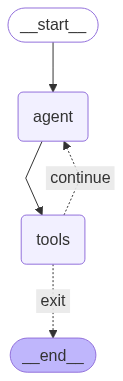

In [48]:
from IPython.display import Image, display

display(Image(compiled.get_graph().draw_mermaid_png()))

In [ ]:
result = compiled.invoke({"messages": []})
print(result)


: USER: i want to dive tmr at 8am

🤖 AI: Just to confirm, you're planning a diving event tomorrow at 8 AM. How long will the event last?

: USER: 3 hours

🤖 AI: 
🔧 USING TOOLS: ['update_local_event']

: USER: 

🤖 AI: Would you like to add any participants to the event?

: USER: nope

🤖 AI: 
🔧 USING TOOLS: ['create_event']
